In [3]:
library(hise)
library(ggplot2)
library(stats)
library(parallel)
library(dplyr)
library(readxl)
library(tidyverse)
library(rstatix)
library(ggpubr)

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘readxl’ was built under R version 4.3.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   

In [4]:
meta_data=read.csv("/home//workspace/IHA_Figure_Revision/Dataset/scRNA_meta_data-2024-05-09.csv")
meta_data$sample.drawDate <- as.Date(meta_data$sample.drawDate)
 
meta_data <- meta_data %>%
  mutate(Flu_Year = case_when(
    sample.drawDate <= as.Date('2020-07-01') ~ '2019-2020',
    sample.drawDate > as.Date('2020-07-01') & sample.drawDate <= as.Date('2021-07-01') ~ '2020-2021',
    sample.drawDate > as.Date('2021-07-01') & sample.drawDate <= as.Date('2022-07-01') ~ '2021-2022',
    sample.drawDate > as.Date('2022-07-01') & sample.drawDate <= as.Date('2023-07-01') ~ '2022-2023',
    TRUE ~ "NA"
  ))

meta_data <- meta_data %>%
  mutate(Flu_Day = case_when(
    sample.visitName	%in% c("Flu Year 1 Day 0","Flu Year 2 Day 0","Immune Variation Day 0") ~ 'Day_0',
    sample.visitName	%in% c("Flu Year 1 Day 7","Flu Year 2 Day 7",'Immune Variation Day 7') ~ 'Day_7',
    sample.visitName	%in% c("Flu Year 1 Day 90","Flu Year 2 Day 90",'Immune Variation Day 90') ~ 'Day_90',
    sample.visitName	%in% c("Flu Year 1 Stand-Alone","Flu Year 2 Stand-Alone","Flu Year 3 Stand-Alone") ~ 'Stand-Alone',
    TRUE ~ sample.visitName
  ))

meta_data <- meta_data %>%
  mutate(Visit_Type = case_when(
    startsWith(sample.visitName, "Flu Year") ~ "FluYear",
    startsWith(sample.visitName, "Immune Variation") ~ "ImmVar",
    TRUE ~ sample.visitName  
  ))

meta_data <- meta_data %>%
  mutate(Year_N = case_when(
    startsWith(sample.visitName, "Flu Year 1") ~ "Year 1",
    startsWith(sample.visitName, "Flu Year 2") ~ "Year 2",
      startsWith(sample.visitName, "Flu Year 2") ~ "Year 3",
    startsWith(sample.visitName, "Immune Variation") ~ "ImmVar",
    TRUE ~ sample.visitName  
  ))

meta_data <- meta_data %>% 
  dplyr::group_by(Year_N, subject.subjectGuid, Visit_Type) %>% 
  dplyr::arrange(Flu_Day) %>% 
  dplyr::mutate(Flu_Year = first(Flu_Year))

meta_data$Visit_Flu_Year<-paste0(meta_data$Visit_Type,"_",meta_data$Flu_Year,"_",meta_data$Flu_Day)

In [15]:
df<-read.csv("/home//workspace/IHA_Figure_Revision/Dataset/MSD/MSD Recent_20231026_092142.csv")

In [16]:
df<-df %>% mutate(Assay=case_when(Assay=="Flu A/Hong Kong (H3N2)" ~ "Flu A/Hong Kong H3",
                              Assay=="Flu A/Michigan (H1N1)" ~ "Flu A/Michigan H1",
                              TRUE ~Assay
                             ))
df$Batch<-substr(df$Notes,1,10)

In [17]:
df<-df%>% filter(Sample.Kit.Barcode	 %in% meta_data$sample.sampleKitGuid)


In [16]:
df<-df %>% arrange(desc(Batch),Notes) %>% 
  distinct(Subject, Visit, Assay,Cohort, Notes,.keep_all = TRUE)
df$Calc..Conc..Mean <-as.numeric(df$Calc..Conc..Mean)

Warning message:
“NAs introduced by coercion”


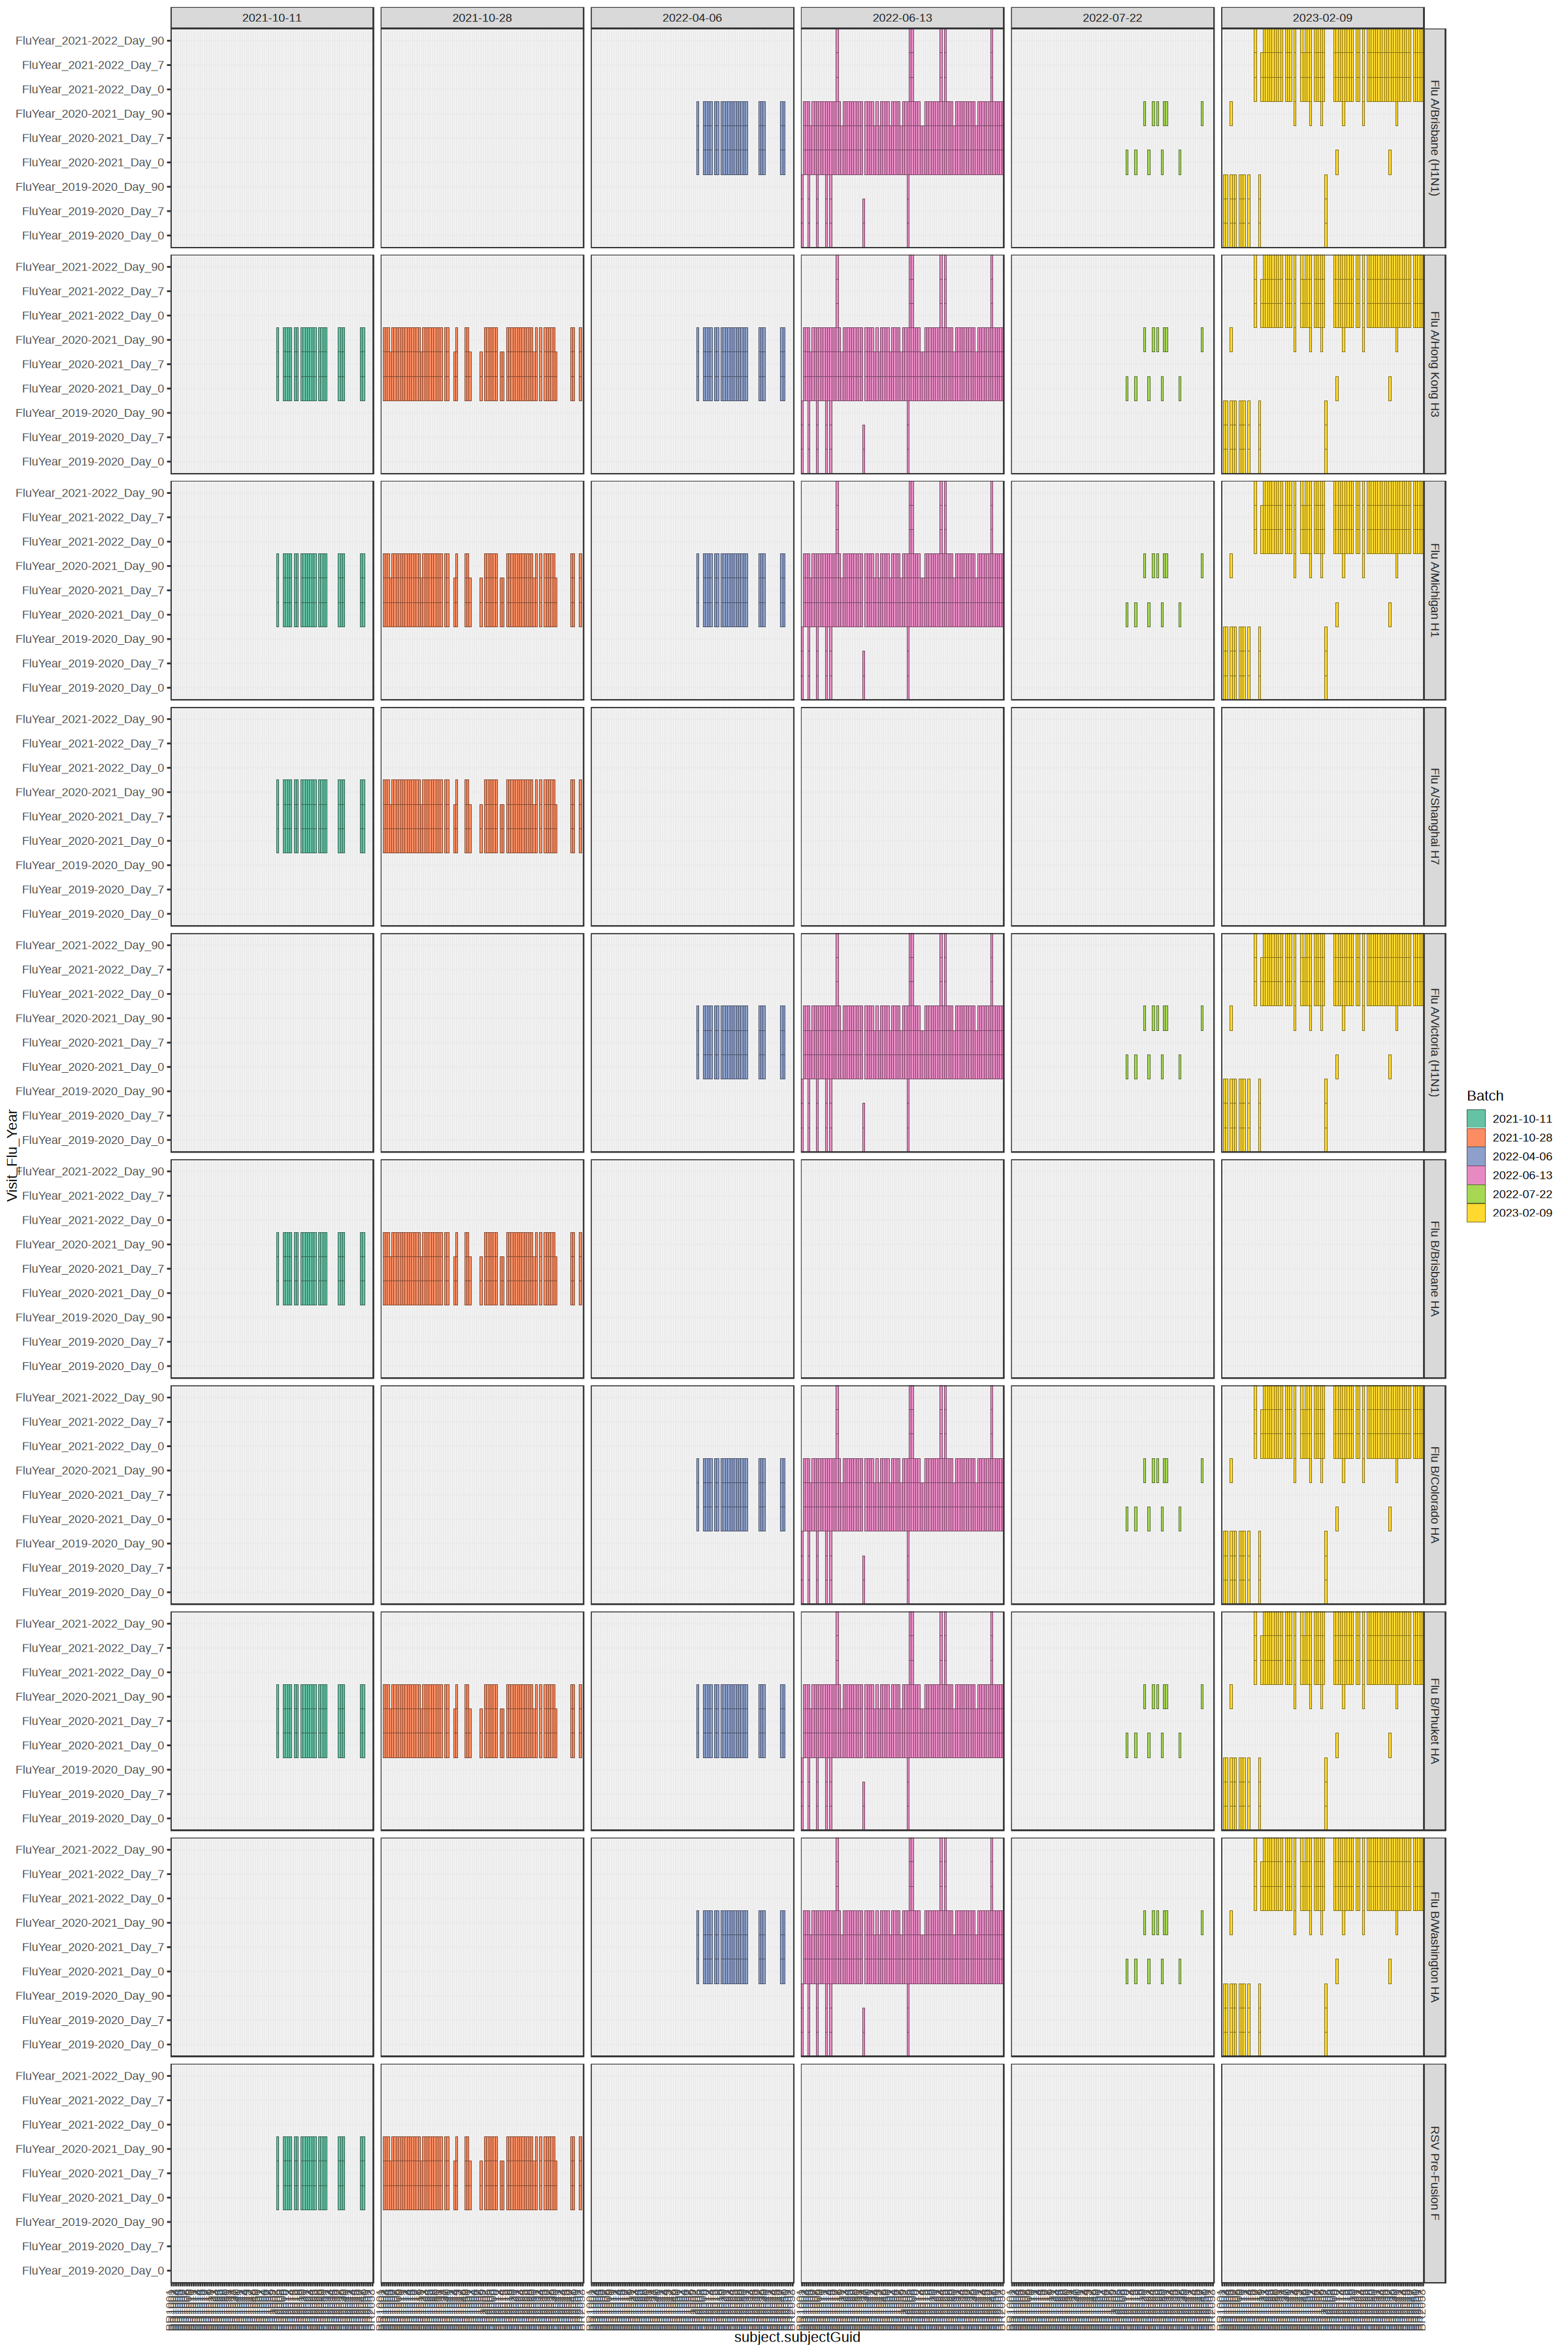

In [17]:
options(repr.plot.width = 20, repr.plot.height =30)
meta_data_vis<-left_join(df ,meta_data,by=c("Sample.Kit.Barcode"="sample.sampleKitGuid"))


ggplot() +
  geom_tile(
      data = meta_data_vis %>% arrange(Notes) ,
      aes(x = subject.subjectGuid,
          y = Visit_Flu_Year,
          fill = Batch),
      color = "black"
  )  +
  scale_fill_brewer(palette = "Set2"
  )+
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  theme_bw(base_size=13) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))+facet_grid(Assay~Batch)

# Duplicated Samples

In [18]:
duplicate_rows <- df[duplicated(df[, c("Sample.Kit.Barcode", "Assay")]) | duplicated(df[, c("Sample.Kit.Barcode",  "Assay")], fromLast = TRUE), ]  %>% arrange(Sample,Assay)

In [19]:
duplicate_rows<-duplicate_rows[grepl("KT",duplicate_rows$Sample.Kit.Barcode		),]

In [20]:
delta_data <- duplicate_rows %>%
  group_by(Sample.Kit.Barcode, Assay) %>%
  arrange(Batch) %>%
  mutate(Delta = Calc..Conc..Mean - lag(Calc..Conc..Mean)) %>%
  filter(!is.na(Delta))


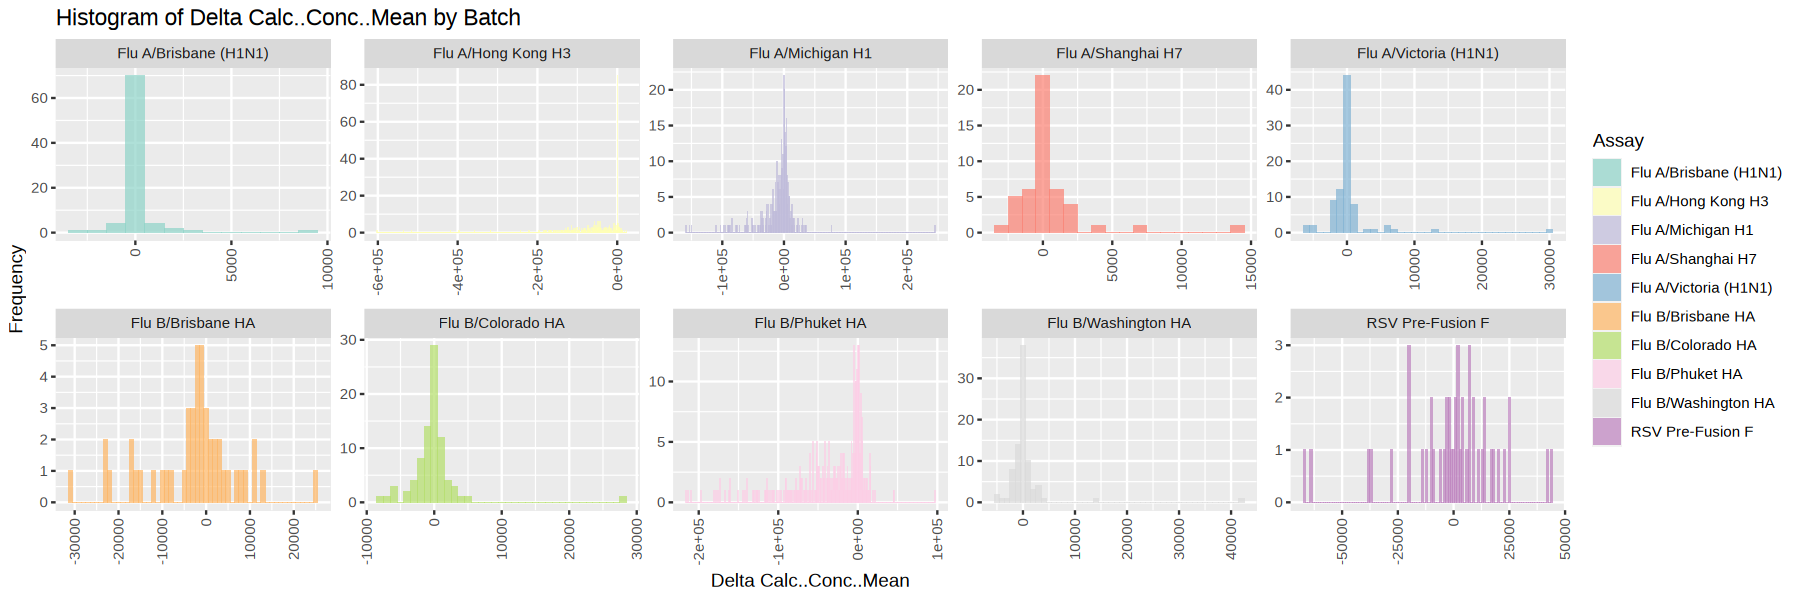

In [21]:
options(repr.plot.width = 15, repr.plot.height =5)

ggplot(delta_data, aes(x = Delta, fill = Assay)) +
  geom_histogram(binwidth = 1000, alpha = 0.7, position = "dodge") +
  facet_wrap(~Assay, scales = "free",ncol=5) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  labs(x = "Delta Calc..Conc..Mean", y = "Frequency", title = "Histogram of Delta Calc..Conc..Mean by Batch")+
  scale_fill_brewer(palette = "Set3")

# CV Distribution

Warning message:
“Removed 5 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 5 rows containing non-finite values (`stat_summary()`).”


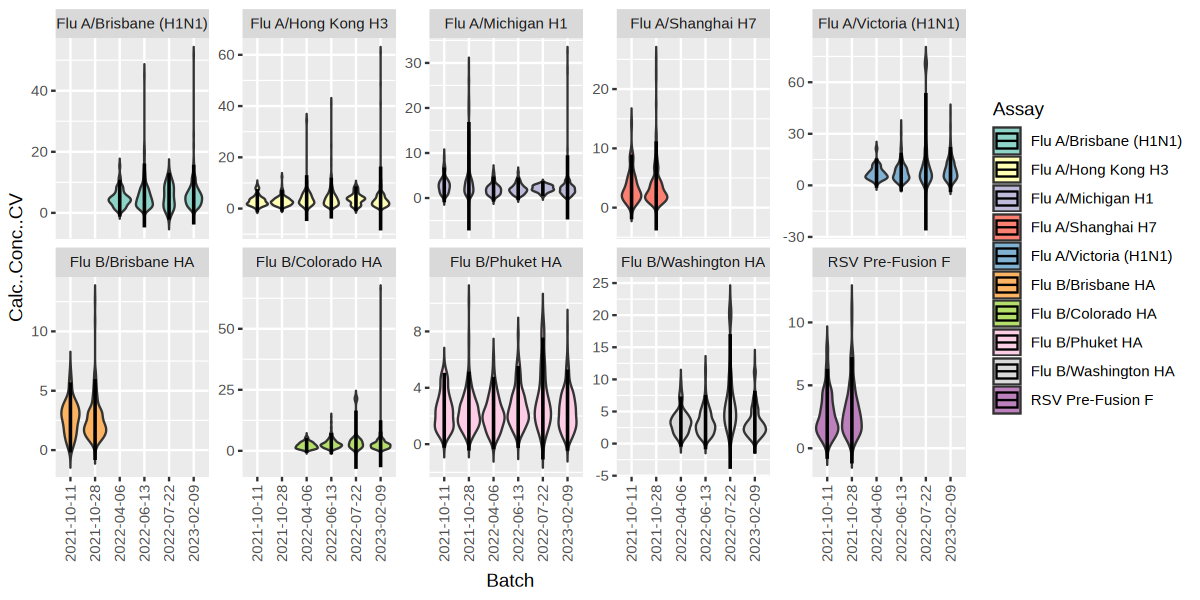

In [22]:
options(repr.plot.width = 10, repr.plot.height =5)


ggplot(df, aes(x = Batch, y=Calc..Conc..CV ,fill = Assay)) +
  facet_wrap(~Assay, scales = "free_y",ncol=5) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))+ geom_violin(trim=FALSE)+ stat_summary(fun.data="mean_sdl",  
                 geom="crossbar", width=0.05 )+
  scale_fill_brewer(palette = "Set3"
  )

# PCA

In [23]:
df_unique<-df %>% arrange(desc(Batch),Notes) %>% filter(grepl("KT",Sample.Kit.Barcode),!Batch %in% c("2022-07-22"))%>% 
  distinct(Subject, Visit, Assay,Cohort,.keep_all = TRUE)

In [27]:

df_wide <- df_unique%>% filter(grepl("KT",Sample.Kit.Barcode),Batch %in% c("2022-06-13","2023-02-09"))%>%
  select(Assay, Sample,Calc..Conc..Mean,Batch) %>%
  pivot_wider(names_from = Assay, values_from = Calc..Conc..Mean)

In [28]:
df_wide<-df_wide[complete.cases(df_wide), ]

In [29]:
pca_result <- prcomp(df_wide[complete.cases(df_wide), ]%>% select(-Sample,-Batch), scale. = TRUE)


In [30]:
pca_scores <- as_tibble(pca_result$x) %>%
  mutate(Sample = df_wide$Sample)%>%
  mutate(Batch = df_wide$Batch)


In [31]:
pca_scores$sample.sampleKitGuid<-paste0("KT",substr(pca_scores$Sample,3,7))

In [32]:
pca_scores<-left_join(as.data.frame(pca_scores),meta_data,by="sample.sampleKitGuid")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


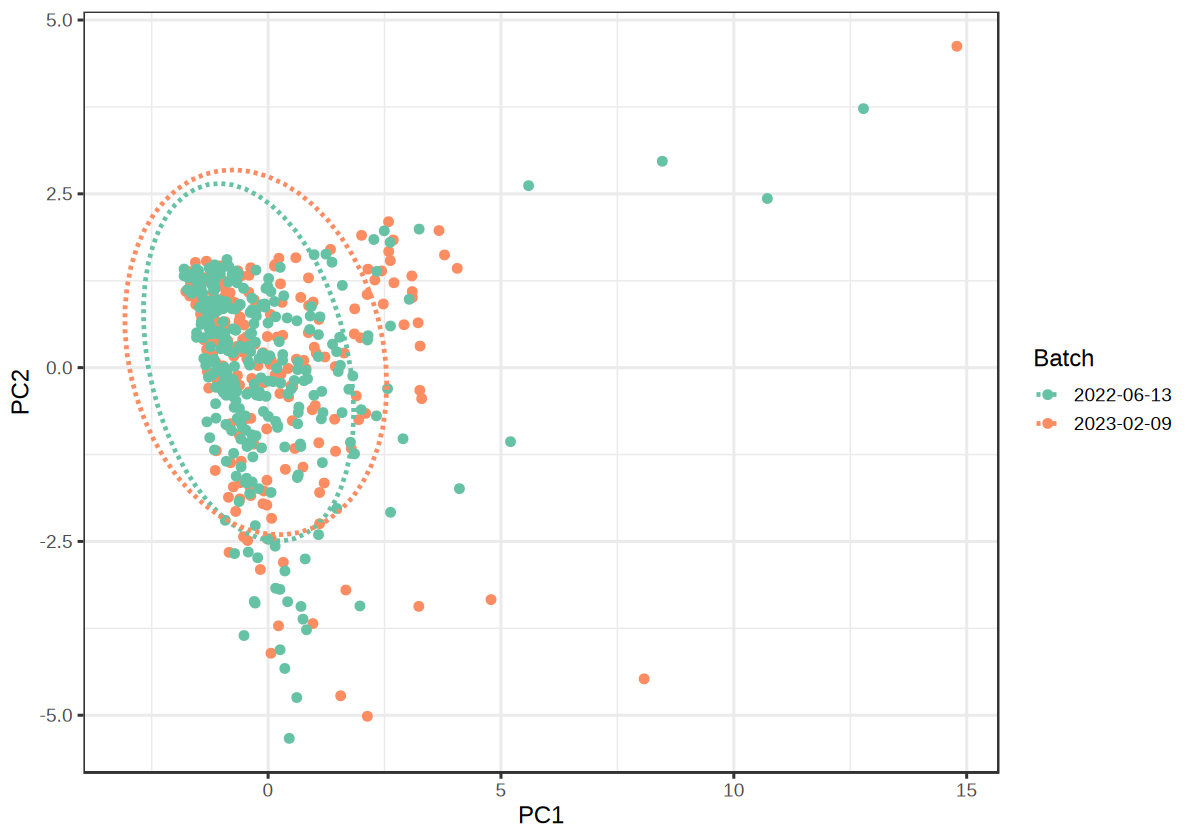

In [33]:
options(repr.plot.width = 10, repr.plot.height =7)
ggplot(pca_scores, aes(x = PC1, y = PC2, color = Batch)) +
  geom_point(size =2) +
  stat_ellipse(aes(group = Batch), linetype = "dashed", size = 1) +

  theme_minimal() +
  labs( x = "PC1", y = "PC2") +theme_bw(base_size=14)+
  scale_color_brewer(palette = "Set2"
  )

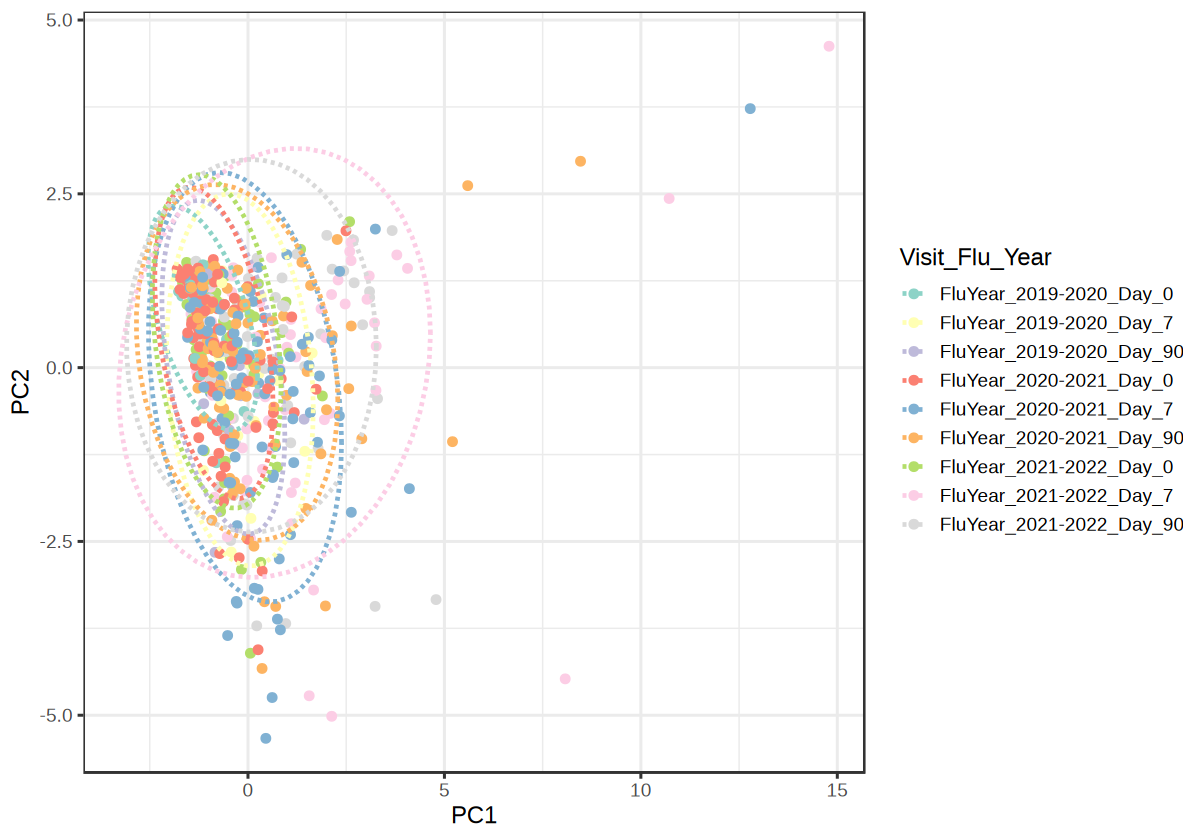

In [34]:
options(repr.plot.width = 10, repr.plot.height =7)
ggplot(pca_scores, aes(x = PC1, y = PC2, color = Visit_Flu_Year)) +
  geom_point(size =2) +
  stat_ellipse(aes(group = Visit_Flu_Year), linetype = "dashed", size = 1) +

  theme_minimal() +
  labs( x = "PC1", y = "PC2") +theme_bw(base_size=14)+
  scale_color_brewer(palette = "Set3"
  )

In [35]:
df_unique<-left_join(df_unique,meta_data,by=c("Sample.Kit.Barcode"="sample.sampleKitGuid"))


In [36]:
write.csv(df_unique, "MSD_All.csv")

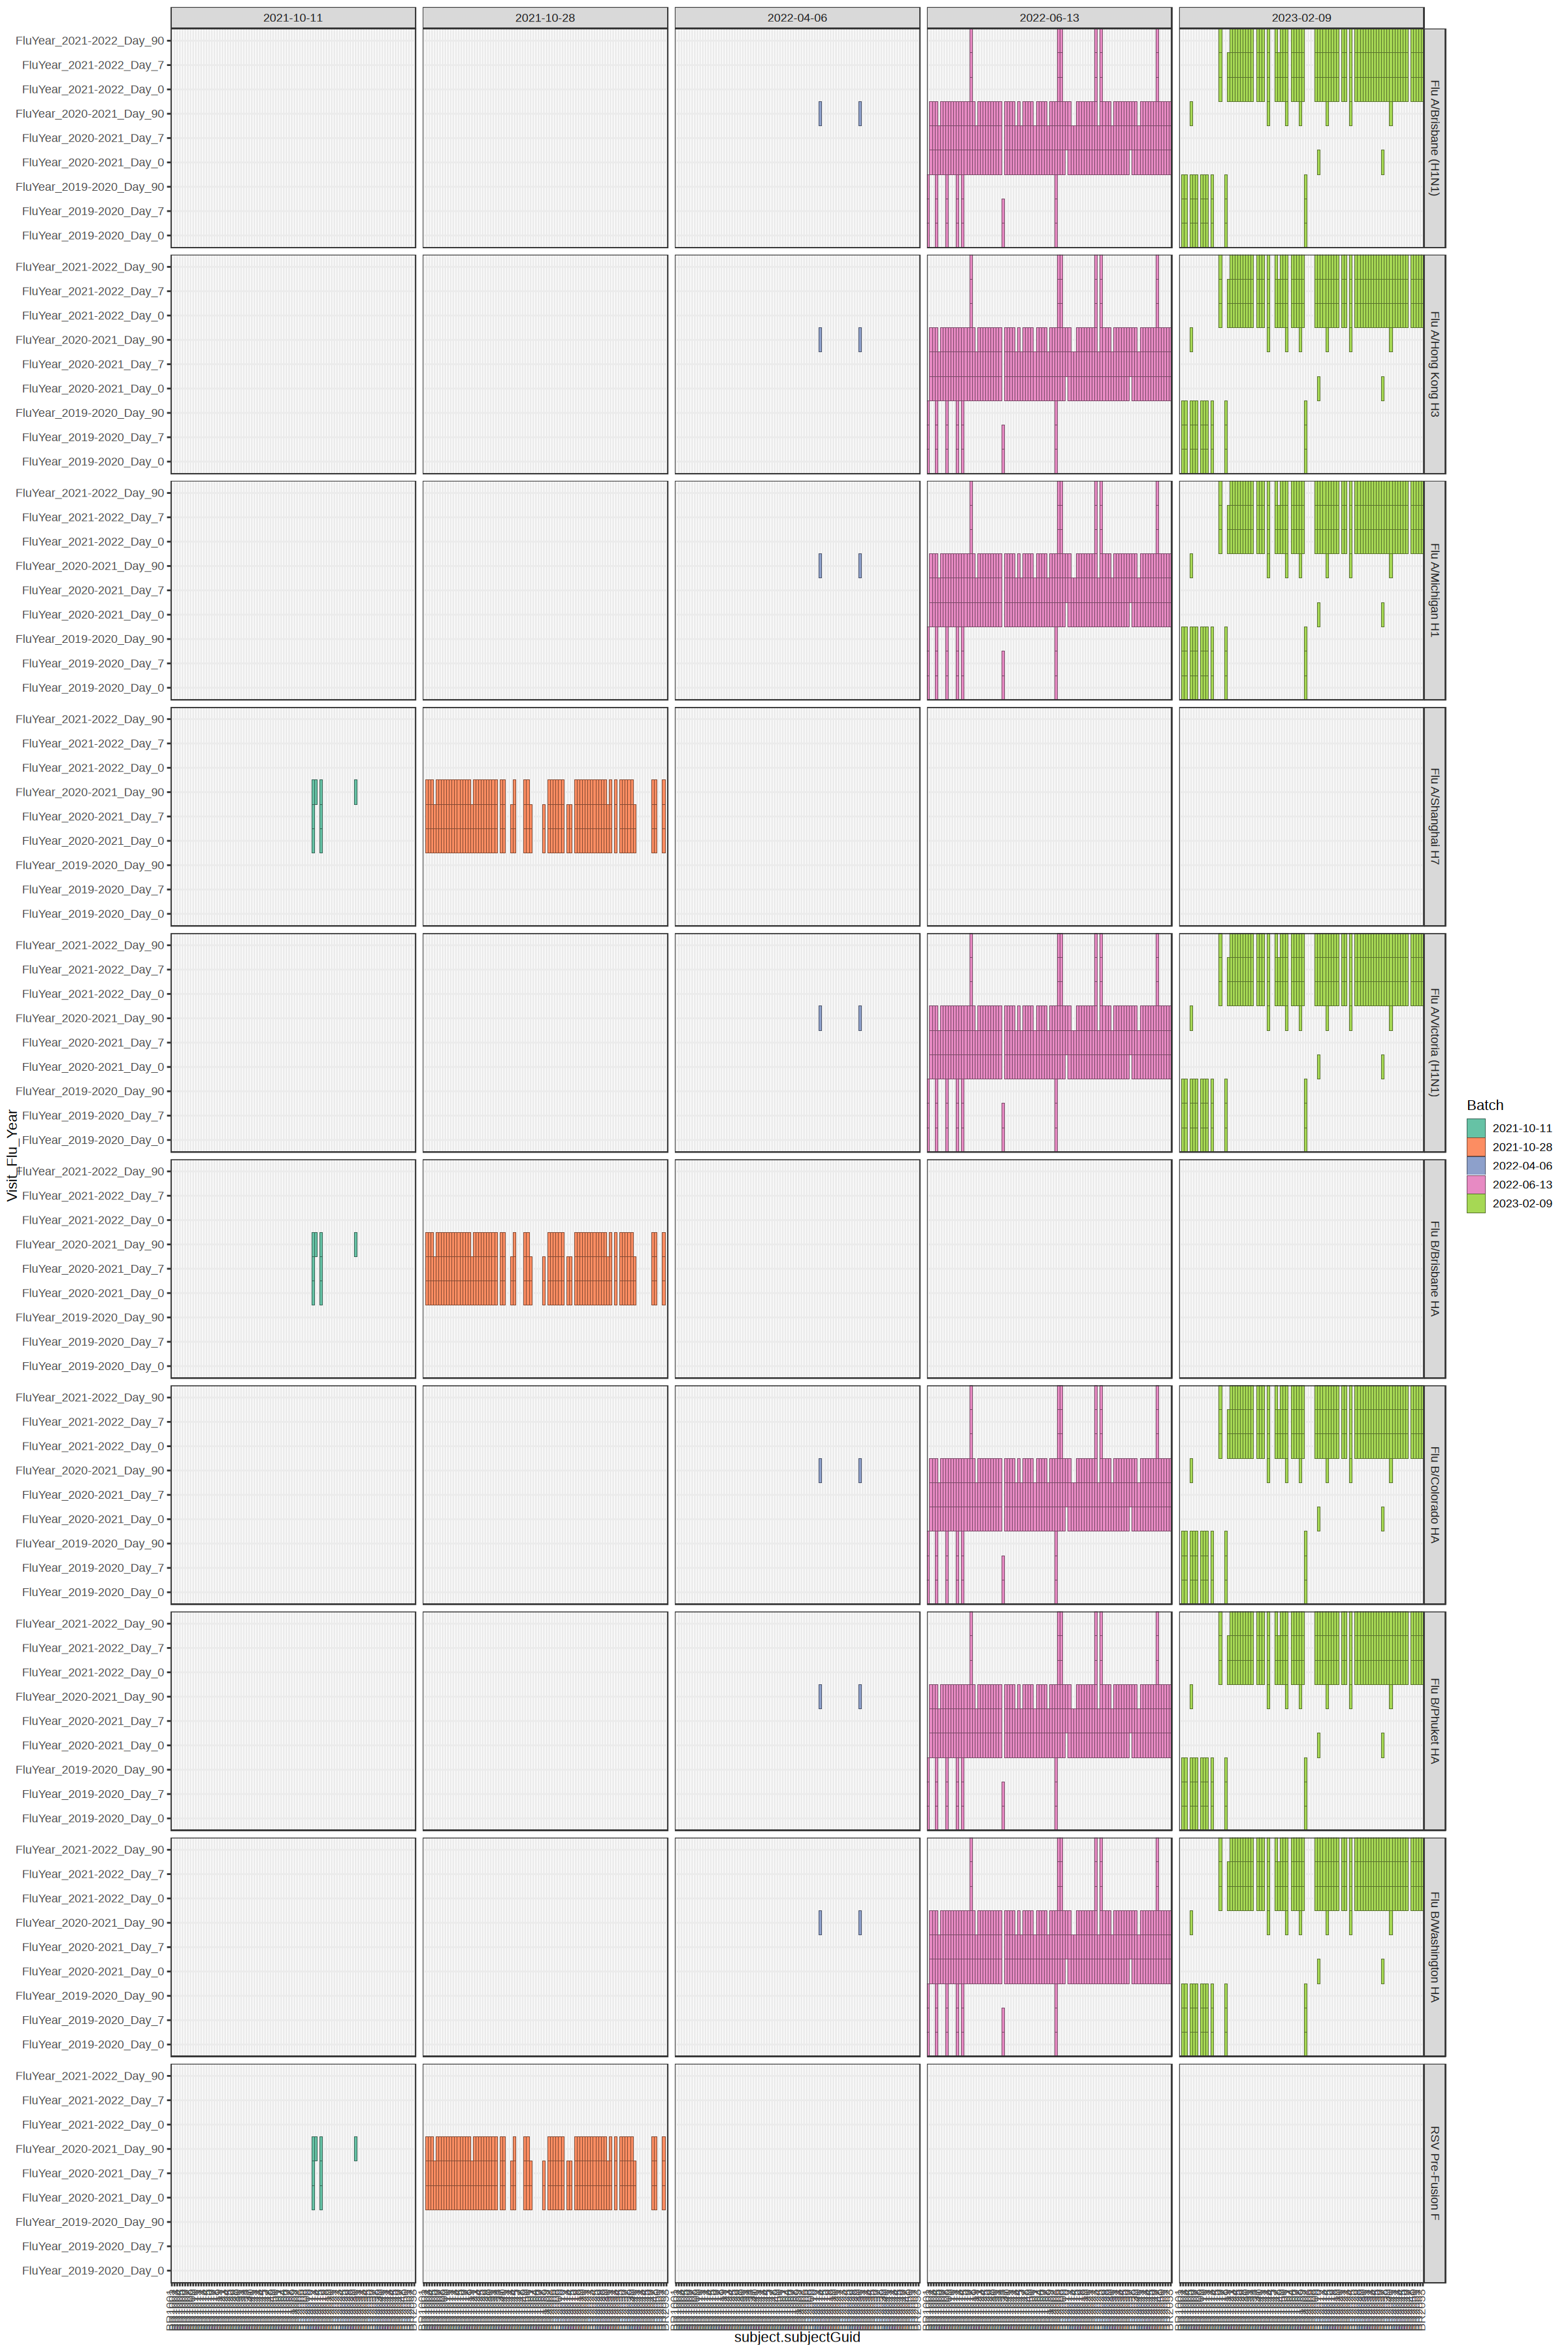

In [37]:
options(repr.plot.width = 20, repr.plot.height =30)


ggplot() +
  geom_tile(
      data = df_unique %>% arrange(Notes) ,
      aes(x = subject.subjectGuid,
          y = Visit_Flu_Year,
          fill = Batch),
      color = "black"
  )  +
  scale_fill_brewer(palette = "Set2"
  )+
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  theme_bw(base_size=13) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))+facet_grid(Assay~Batch)#+ guides(fill = "none")